# Install library for reading the dataset files

In [ ]:
pip install wfdb

# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import wfdb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
import random
import os
import time
import math

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, ReLU, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Add, GlobalAveragePooling1D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import seaborn as sns

# Define a function to set the random generator for reproducibility


In [131]:
def reset_random_seeds(seed=0):
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
   tf.keras.utils.set_random_seed(seed)
   os.environ['PYTHONHASHSEED']=str(seed)
   os.environ['TF_DETERMINISTIC_OPS'] = '1'
   os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

reset_random_seeds()

# Define Classes

In [99]:
# classes=['NORM','STTC','AMI','IMI','LAFB/LPFB','LVH','IRBBB','CLBBB','ISCA','CRBBB']# 10 subclasses
# classes=['NORM','STTC','AMI','IMI','LAFB/LPFB','LVH','IRBBB','CLBBB','NST_','ISCA','CRBBB','ISC_','IVCD','_AVB','ISCI']# 15 subclasses

classes=['NORM', 'MI', 'STTC', 'CD', 'HYP'] # 5 Superclasses

# Preprocess CSV File

In [100]:
# path = '/kaggle/input/ptbxl-dataset/PTBXL/'
path='/kaggle/input/ptbxl-original-dataset/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100
# load and convert annotation data
X_csv = pd.read_csv(path+'ptbxl_database.csv') 
X_csv.scp_codes = X_csv.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0) 
agg_df = agg_df[agg_df['diagnostic_class'].isin(classes)] # 5 Superclasses
# agg_df = agg_df[agg_df['diagnostic_subclass'].isin(classes)] # 10-15 Subclasses

In [101]:
def aggregate_diagnostic(x_dic):
    tmp = []
    for key in x_dic.keys():
        if key in agg_df.index and x_dic[key]>=80: # include only disorders that are identified by a likelihood of > 80%
            tmp.append(agg_df.loc[key].diagnostic_class) # 5 Superclasses
            # tmp.append(agg_df.loc[key].diagnostic_subclass) # 10-15 Subslasses
    return tmp


# Apply diagnostic superclass
X_csv['diagnostic_superclass'] = X_csv.scp_codes.apply(aggregate_diagnostic)

X_csv


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,[STTC]
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,[NORM]
21834,21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,[]
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,[NORM]


In [ ]:
# Display the number of missing values in each column
missing_counts = X_csv.isnull().sum()
print(missing_counts)

In [102]:
# remove empty diagnostic_superclass -> []
reset_random_seeds()
X_csv = X_csv[X_csv['diagnostic_superclass'].apply(lambda x: x != [])]
X_csv = X_csv[X_csv['electrodes_problems'].isnull()] # exclude rows with electrodes problems
X_csv['diagnostic_superclass'] = X_csv['diagnostic_superclass'].apply(lambda x: x[0]) # if multiple classes, retrieve the first one only

# Take some features related to the person
# We will select 'age' and 'sex'
# 'age' has some empty record. So, drop them
X_csv.dropna(subset=['age'], inplace=True)

X_csv

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,21832,7954.0,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-30 14:14:25,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/21000/21832_lr,records500/21000/21832_hr,LAFB/LPFB
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,STTC
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,NORM
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,NORM


# Select Patient Information

## X2 is the data for the second branch of the model

In [103]:

X2 = pd.DataFrame(index=X_csv.index)
X2['age'] = X_csv.age
X2['sex'] = X_csv.sex

X2 = X2.astype({'age': int, 'sex': int})

missing_counts = X2.isnull().sum()
print(missing_counts)

X2

age    0
sex    0
dtype: int64


,age,sex
0,56,1
1,19,0
2,37,1
3,24,0
4,19,1
...,...,...
21831,63,0
21832,67,1
21833,93,0
21835,64,1


# Load ECG Data

In [104]:
def load_raw_data(df, sampling_rate, path):
    data=[]
    if sampling_rate == 100:
        for f in tqdm(df.filename_lr): #
            signal, meta = wfdb.rdsamp(path+f)
            data.append(signal)
    else:
        for f in tqdm(df.filename_hr):
            signal, meta = wfdb.rdsamp(path+f)
            data.append(signal)
        
    return  np.array(data)


# Load raw signal data
X_ecg = load_raw_data(X_csv, sampling_rate, path)


100%|██████████| 17629/17629 [01:52<00:00, 157.07it/s]


## Data Size

## X1 is the data for the first branch of the model

In [105]:
# How many ECG channels to take: 1 -> 12
X1 = X_ecg#[:,:,:10] # take them all
print(X1.shape)

(17629, 1000, 12)


## Plot Sample

In [ ]:
# Plot Sample
test_sample = X_ecg[np.where(X_csv.index == 1)][0]
print(test_sample.shape)
plt.figure(figsize=(15, 18))
m,n = X_ecg.shape[2], 1
for i in range (m):
    ax = plt.subplot(m, n, i + 1)
    patch_img = test_sample[:,i]
    plt.plot(patch_img)

plt.savefig('ecg.png')
plt.show()

## For Binary Classification (Normal and Disease Classes)

In [16]:
# For Binary Classification (Norm and Disease Classes)
classes=['NORM', 'Disease']

X_csv['diagnostic_superclass'] = X_csv['diagnostic_superclass'].apply(lambda x: 'Disease' if x != 'NORM' else x) 

X_csv

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,NORM
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,NORM
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,NORM
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,NORM
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,NORM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,21832,7954.0,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-05-30 14:14:25,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/21000/21832_lr,records500/21000/21832_hr,Disease
21832,21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,...,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,Disease
21833,21834,20703.0,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,NORM
21835,21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,...,NaN,NaN,NaN,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,NORM


# Output Encoding

In [106]:
Y = pd.DataFrame(0, index=X_csv.index, columns=classes, dtype='int') #classes

for i in Y.index:
    k = X_csv.loc[i].diagnostic_superclass
    Y.loc[i, k] = 1

Y.head()

,NORM,STTC,AMI,IMI,LAFB/LPFB,LVH,IRBBB,CLBBB,ISCA,CRBBB
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


## Classes Count

In [ ]:
pf=Y.value_counts()
pdd=pd.DataFrame(pf)
pdd

# Plot Bar Plot

In [ ]:
# Plot Bar Plot
def pie_bar_plot(df, col):
    plt.figure(figsize=(8, 8))
    
    # Extract value counts for the specified column
    unique_values = df[col].value_counts().index.to_numpy()
    value_counts = df[col].value_counts()#.sort_index()
    
    ax1 = value_counts
    plt.title(f"Distribution by record counts", fontweight="black", size=14, pad=15)
    colors = sns.color_palette('Set2', len(ax1))
    plt.pie(ax1.values, labels=None, autopct="", startangle=90, colors=colors)
    center_circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(center_circle)

    # Create a legend with labels and values
    # Display count and percentage values
    #legend_labels = [f"{label}: {value} ({round(100*value/sum(value_counts),2)}%)" for label, value in zip(unique_values, value_counts)]
    # Display count values
    legend_labels = [f"{' '+label}: {value} " for label, value in zip(unique_values, value_counts)] # add 'space' before label name because legend will not show the labels starting by '_'
    plt.legend(legend_labels, loc="lower right", fontsize=10)

    plt.savefig('Count_barplot.png')
    plt.show()

pie_bar_plot(X_csv, 'diagnostic_superclass')

# Split data into train, validation, and test

In [120]:
## train_fold = 1, 2, 3, 4, 5, 6, 7, 8
valid_fold = 9
test_fold = 10
# Train
X1_train = X1[X_csv.strat_fold < valid_fold]
X2_train = X2[X_csv.strat_fold < valid_fold]
YY_train = Y[X_csv.strat_fold < valid_fold]

# Valid
X1_valid = X1[X_csv.strat_fold == valid_fold]
X2_valid = X2[X_csv.strat_fold == valid_fold]
YY_valid = Y[X_csv.strat_fold == valid_fold]

# Test
X1_test = X1[X_csv.strat_fold == test_fold]
X2_test = X2[X_csv.strat_fold == test_fold]
YY_test = Y[X_csv.strat_fold == test_fold]

print('Train:',X1_train.shape, X2_train.shape, YY_train.shape)
print('Validation:',X1_valid.shape, X2_valid.shape, YY_valid.shape)
print('Test:', X1_test.shape, X2_test.shape, YY_test.shape)

Train: (14150, 1000, 12) (14150, 2) (14150, 10)
Validation: (1736, 1000, 12) (1736, 2) (1736, 10)
Test: (1743, 1000, 12) (1743, 2) (1743, 10)


In [121]:
# For Binary Classification --> Normal and a specific disease
# classes=['NORM', 'MI', 'STTC', 'CD', 'HYP'] # 5 classes
classes=['NORM','STTC','AMI','IMI','LAFB/LPFB','LVH','IRBBB','CLBBB','ISCA','CRBBB']# 10 subclasses

tar_col='CLBBB' # column to target with 'Normal'
cl=list(classes)
cl.remove('NORM')
cl.remove(tar_col)
classes=['NORM', tar_col]

# Step 1: Apply the filter to training data
mask_train = (YY_train['NORM'] == 1) | (YY_train[tar_col] == 1)
X1_train_filtered = X1_train[mask_train]
X2_train_filtered = X2_train[mask_train]
Y_train_filtered = YY_train[mask_train].drop(columns=cl)

# Step 2: Apply the filter to validation data
mask_valid = (YY_valid['NORM'] == 1) | (YY_valid[tar_col] == 1)
X1_valid_filtered = X1_valid[mask_valid]
X2_valid_filtered = X2_valid[mask_valid]
Y_valid_filtered = YY_valid[mask_valid].drop(columns=cl)

# Step 3: Apply the filter to test data
mask_test = (YY_test['NORM'] == 1) | (YY_test[tar_col] == 1)
X1_test_filtered = X1_test[mask_test]
X2_test_filtered = X2_test[mask_test]
Y_test_filtered = YY_test[mask_test].drop(columns=cl)

# Check the shapes after filtering
print("Train shapes:", X1_train_filtered.shape, X2_train_filtered.shape, Y_train_filtered.shape)
print("Validation shapes:", X1_valid_filtered.shape, X2_valid_filtered.shape, Y_valid_filtered.shape)
print("Test shapes:", X1_test_filtered.shape, X2_test_filtered.shape, Y_test_filtered.shape)

Train shapes: (7563, 1000, 12) (7563, 2) (7563, 2)
Validation shapes: (933, 1000, 12) (933, 2) (933, 2)
Test shapes: (951, 1000, 12) (951, 2) (951, 2)


In [19]:
# 5 classes, 10 classes, 15 classes, and 2 classes: Normal and Disease
# classes=['NORM','STTC','AMI','IMI','LAFB/LPFB','LVH','IRBBB','CLBBB','NST_','ISCA','CRBBB','ISC_','IVCD','_AVB','ISCI']#subclasses

Y_train=YY_train
Y_valid=YY_valid
Y_test=YY_test

In [122]:
# For Binary Classification --> Normal and a specific disease

Y_train=Y_train_filtered
Y_valid=Y_valid_filtered
Y_test=Y_test_filtered
X1_train=X1_train_filtered
X2_train=X2_train_filtered
X1_valid=X1_valid_filtered
X2_valid=X2_valid_filtered
X1_test=X1_test_filtered
X2_test=X2_test_filtered

## Augmentation for Train Samples


In [ ]:
def select_augmentation(s, g):
    # s: input 
    # g: type of augmentation:
    #  0 -> Add noise 
    #  1 -> Amplify
    #  2 -> Attenuate
    
    if g==0:
        noise_level=0.01
        noise = np.random.normal(0, noise_level, s.shape)
        return s + noise
    elif g==1:
        amp_level_low=1
        amp_level_high=100
        a=np.random.randint(amp_level_low, amp_level_high)/1000 #[0.001 ->0.01[
        return s * (1+a) 
    else:
        att_level_low=1
        att_level_high=100
        a=np.random.randint(att_level_low, att_level_high)/1000 #[0.001 ->0.01[
        return s * (1-a)         

def augment(sig, new_num):
    # sig: input signal to be augmented
    # new_num: needed number of augmented samples
    arr=[]
    for i in range(new_num):
        select=np.random.randint(3)
        s_g=select_augmentation(sig, select)
        arr.append(s_g)
    return arr

In [ ]:
# Augmenting X_train and Y_train
reset_random_seeds()
for t_class in classes:
    if t_class=='NORM': continue
    print('--------------------------------------')
    print('Current class: ',t_class)
    X1_train_c = X1[(X_csv.strat_fold < valid_fold) & (X_csv.diagnostic_superclass ==t_class)]
    Y_train_c = Y[(X_csv.strat_fold < valid_fold) & (X_csv.diagnostic_superclass ==t_class)]
    print('Count before augmentation: ',X1_train_c.shape)

    Y_train_NORM = Y[(X_csv.strat_fold < valid_fold) & (X_csv.diagnostic_superclass =='NORM')]

    new_num=math.floor(Y_train_NORM.shape[0]/Y_train_c.shape[0])-1
    Xtrain_augmented_c = np.array([augment(sig=x, new_num=new_num) for x in X1_train_c])
    # X2_train = X2[X_csv.strat_fold < valid_fold]
    
    Xtrain_augmented_c=np.reshape(Xtrain_augmented_c,(-1,X1_train.shape[1],X1_train.shape[2]))
    print('Count after augmentation: ',Xtrain_augmented_c.shape[0]+X1_train_c.shape[0])
    X1_train=np.append(X1_train,Xtrain_augmented_c, axis=0)
     
    num_copies = Xtrain_augmented_c.shape[0]
    row_to_repeat = Y_train[Y_train[t_class] == 1].iloc[[0]]
    repeated_rows= pd.DataFrame(np.repeat(row_to_repeat, num_copies, axis=0), columns=Y_train.columns)
    Y_train = pd.concat([Y_train, repeated_rows], ignore_index=True).reset_index(drop=True)

In [ ]:
# Shuffle the data points
reset_random_seeds()
Y_train=Y_train.reset_index(drop=True)
indices = np.random.permutation(len(Y_train))
X1_train, Y_train = X1_train[indices], Y_train.loc[indices]

In [ ]:
Y_train

In [ ]:
# Class Count
pf=Y_train.value_counts()
pdd=pd.DataFrame(pf)
pdd

In [ ]:
# Plot Pie Plot
# Convert one-hot encoding to class labels (index of 1 in each row)
Y_train=Y_train.reset_index(drop=True)
class_labels = np.argmax(Y_train, axis=1)

# Count occurrences of each class
class_counts = pd.Series(class_labels).value_counts().sort_index()
colors = sns.color_palette('Set2', len(class_counts))
# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels=[f' {i}' for i in Y_train.columns], autopct='%1.1f%%', colors=colors)
# plt.title("Class Distribution (Pie Chart)")
plt.savefig('CountTrain_barplot.png')

plt.show()

## End Augmentation for Train


In [ ]:
# Y_test.shape

pf=Y_train.value_counts()
pdd=pd.DataFrame(pf)
pdd

# Prepare data

In [123]:
num_classes = len(classes)

X1_train_0=X1_train[:,:,0]
X1_train_1=X1_train[:,:,1]
X1_train_2=X1_train[:,:,2]
X1_train_3=X1_train[:,:,3]
X1_train_4=X1_train[:,:,4]
X1_train_5=X1_train[:,:,5]
X1_train_6=X1_train[:,:,6]
X1_train_7=X1_train[:,:,7]
X1_train_8=X1_train[:,:,8]
X1_train_9=X1_train[:,:,9]
X1_train_10=X1_train[:,:,10]
X1_train_11=X1_train[:,:,11]

X1_valid_0=X1_valid[:,:,0]
X1_valid_1=X1_valid[:,:,1]
X1_valid_2=X1_valid[:,:,2]
X1_valid_3=X1_valid[:,:,3]
X1_valid_4=X1_valid[:,:,4]
X1_valid_5=X1_valid[:,:,5]
X1_valid_6=X1_valid[:,:,6]
X1_valid_7=X1_valid[:,:,7]
X1_valid_8=X1_valid[:,:,8]
X1_valid_9=X1_valid[:,:,9]
X1_valid_10=X1_valid[:,:,10]
X1_valid_11=X1_valid[:,:,11]

X1_test_0=X1_test[:,:,0]
X1_test_1=X1_test[:,:,1]
X1_test_2=X1_test[:,:,2]
X1_test_3=X1_test[:,:,3]
X1_test_4=X1_test[:,:,4]
X1_test_5=X1_test[:,:,5]
X1_test_6=X1_test[:,:,6]
X1_test_7=X1_test[:,:,7]
X1_test_8=X1_test[:,:,8]
X1_test_9=X1_test[:,:,9]
X1_test_10=X1_test[:,:,10]
X1_test_11=X1_test[:,:,11]

X2_train_ar=X2_train.to_numpy()
X2_valid_ar=X2_valid.to_numpy()
X2_test_ar=X2_test.to_numpy()


X2_train_ar = np.reshape(X2_train_ar, (X2_train_ar.shape[0],X2_train_ar.shape[1],1))
X2_valid_ar = np.reshape(X2_valid_ar, (X2_valid_ar.shape[0],X2_valid_ar.shape[1],1))
X2_test_ar = np.reshape(X2_test_ar, (X2_test_ar.shape[0],X2_test_ar.shape[1],1))

X2_train_0=X2_train_ar[:,0]
X2_train_1=X2_train_ar[:,1]

X2_valid_0=X2_valid_ar[:,0]
X2_valid_1=X2_valid_ar[:,1]

X2_test_0=X2_test_ar[:,0]
X2_test_1=X2_test_ar[:,1]


# Create the model

## Create the first branch of the model (ECG Data)

In [124]:
reset_random_seeds()  

input_shape= (X1_train_0.shape[1],1) 
print(input_shape)

X1_0_input = Input(input_shape, name="X1_0_input")
X1_1_input = Input(input_shape, name="X1_1_input")
X1_2_input = Input(input_shape, name="X1_2_input")
X1_3_input = Input(input_shape, name="X1_3_input")
X1_4_input = Input(input_shape, name="X1_4_input")
X1_5_input = Input(input_shape, name="X1_5_input")
X1_6_input = Input(input_shape, name="X1_6_input")
X1_7_input = Input(input_shape, name="X1_7_input")
X1_8_input = Input(input_shape, name="X1_8_input")
X1_9_input = Input(input_shape, name="X1_9_input")
X1_10_input = Input(input_shape, name="X1_10_input")
X1_11_input = Input(input_shape, name="X1_11_input")

X1_input= Concatenate(name="X1_input")([X1_0_input, X1_1_input, X1_2_input, X1_3_input, X1_4_input, X1_5_input, X1_6_input, X1_7_input, X1_8_input, X1_9_input, X1_10_input, X1_11_input])

(1000, 1)


## Choose the model to use: CNN or VGG

In [112]:
used_model='CNN' # 'VGG'  'CNN' 

In [125]:
reset_random_seeds()  

if used_model =='CNN':
    # CNN
    XX = Conv1D(32, 3, padding='same', activation='relu')(X1_input)
    XX = MaxPooling1D(2)(XX)
    XX = BatchNormalization()(XX)
    
    XX = Conv1D(64, 3, padding='same', activation='relu')(XX)
    XX = MaxPooling1D(2)(XX)
    XX = BatchNormalization()(XX)
    
    XX = Conv1D(128, 3, padding='same', activation='relu')(XX)
    XX = MaxPooling1D(2)(XX)
    XX = BatchNormalization()(XX)
    
    XX = Conv1D(256, 3, padding='same', activation='relu')(XX)
    XX = MaxPooling1D(2)(XX)
    XX = BatchNormalization()(XX)
    
    XX = Conv1D(512, 3, padding='same', activation='relu')(XX)
    XX = MaxPooling1D(2)(XX)
    XX = BatchNormalization()(XX)
    
    XX = GlobalAveragePooling1D()(XX)
    
    XX = Dropout(0.4)(XX)
    
    XX = Dense(100, activation='relu')(XX)
    
    XX = Dropout(0.4)(XX)
    X1_output = Dense(32, activation="relu", name="X1_output")(XX)
else:
    # VGG1D
    # First Conv Block
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(X1_input)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Second Conv Block
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Third Conv Block
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Fourth Conv Block
    x = Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=512, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    X1_output = Dropout(0.5)(x)


## Create the second branch (Patient Data)

In [126]:
reset_random_seeds() 

input_shape = (X2_train_0.shape[1], 1)
print(input_shape)


X2_0_input = Input(input_shape, name="X2_0_input")
X2_1_input = Input(input_shape, name="X2_1_input")

X2_input = Concatenate(name="X2_input")([X2_0_input, X2_1_input])


(1, 1)


In [127]:
# Model for X2
reset_random_seeds()  


XX = Dense(100, activation='relu')(X2_input)

XX = Dropout(0.4)(XX)
XX = Dense(64, activation='relu')(XX)
XX = Dropout(0.4)(XX)
XX = Dense(32, activation='relu')(XX)
XX = Dropout(0.2)(XX)

XX = Dense(16, activation="relu")(XX)
X2_output = GlobalAveragePooling1D(name="X2_output")(XX)


## Concatenate the two branches 

In [128]:
# Concatenate
reset_random_seeds()  

Z = Concatenate(name="Z_concat")([X1_output, X2_output])

Z = Dense(10, activation='relu')(Z)
Z = Dropout(0.2)(Z)
Z = Dense(10, activation='relu')(Z)
Z = Dropout(0.2)(Z)

# Z:with patient data,  X1_output:without patient data 
concat_output = Dense(num_classes, activation="softmax")(Z)

model = Model(inputs=[X1_0_input, X1_1_input,X1_2_input, X1_3_input, X1_4_input, X1_5_input,X1_6_input, X1_7_input,X1_8_input, X1_9_input, X1_10_input, X1_11_input, X2_0_input, X2_1_input], outputs=concat_output) #, X2_0_input, X2_1_input

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='crossentropy', metrics=['accuracy','Precision','Recall','F1Score'], jit_compile=False) #binary_crossentropy   categorical_crossentropy

# model.summary()


## Plot the model

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

# Fit the model

In [129]:
# Step 3: Define callbacks
reset_random_seeds()  

# 1. Save the best model during training
checkpoint = ModelCheckpoint(filepath='best_model.keras', 
                             monitor='val_accuracy', 
                             save_best_only=True, 
                             verbose=1, 
                             mode='max')

# 2. Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=20, 
                               restore_best_weights=True, 
                               verbose=1)

# 3. Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5, 
                              min_lr=0.00001, 
                              verbose=1)

start_time = time.time()
history = model.fit([X1_train_0,X1_train_1,X1_train_2,X1_train_3,X1_train_4,X1_train_5,X1_train_6,X1_train_7,X1_train_8,X1_train_9,X1_train_10,X1_train_11, X2_train_0,X2_train_1], Y_train, #, X2_train_0,X2_train_1
                         epochs=60, 
                         batch_size=16, 
                         validation_data=([X1_valid_0,X1_valid_1,X1_valid_2,X1_valid_3,X1_valid_4,X1_valid_5,X1_valid_6,X1_valid_7,X1_valid_8,X1_valid_9,X1_valid_10,X1_valid_11, X2_valid_0,X2_valid_1], Y_valid),#, X2_valid_0,X2_valid_1
                         callbacks=[checkpoint, early_stopping, reduce_lr], 
                         verbose=1)
training_duration = time.time() - start_time


Epoch 1/60
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - F1Score: 0.5036 - Precision: 0.9269 - Recall: 0.9269 - accuracy: 0.9269 - loss: 0.2997
Epoch 1: val_accuracy improved from -inf to 0.94748, saving model to best_model.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - F1Score: 0.5036 - Precision: 0.9270 - Recall: 0.9270 - accuracy: 0.9270 - loss: 0.2995 - val_F1Score: 0.4865 - val_Precision: 0.9475 - val_Recall: 0.9475 - val_accuracy: 0.9475 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 2/60
473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - F1Score: 0.8448 - Precision: 0.9745 - Recall: 0.9745 - accuracy: 0.9745 - loss: 0.0636
Epoch 2: val_accuracy improved from 0.94748 to 0.99893, saving model to best_model.keras
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - F1Score: 0.8448 - Precision: 0.9745 - Recall: 0.9745 - accuracy: 0.9745 - loss: 0.0636 - val_F1Score: 0.9946 - val_Precision: 0.9989 - val_Recall: 0.9989 - val_accuracy: 0.9989 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 3/60


# Plot Learning curves

In [ ]:
# Step 5: Plot the accuracy and loss growth graph
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Growth over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('accuracy_loss.png')

plt.show()


# Evaluate the model and plot the confusion matrix

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - F1Score: 0.9650 - Precision: 0.9974 - Recall: 0.9974 - accuracy: 0.9974 - loss: 0.0119
Training time (Sec):  314.8006281852722
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


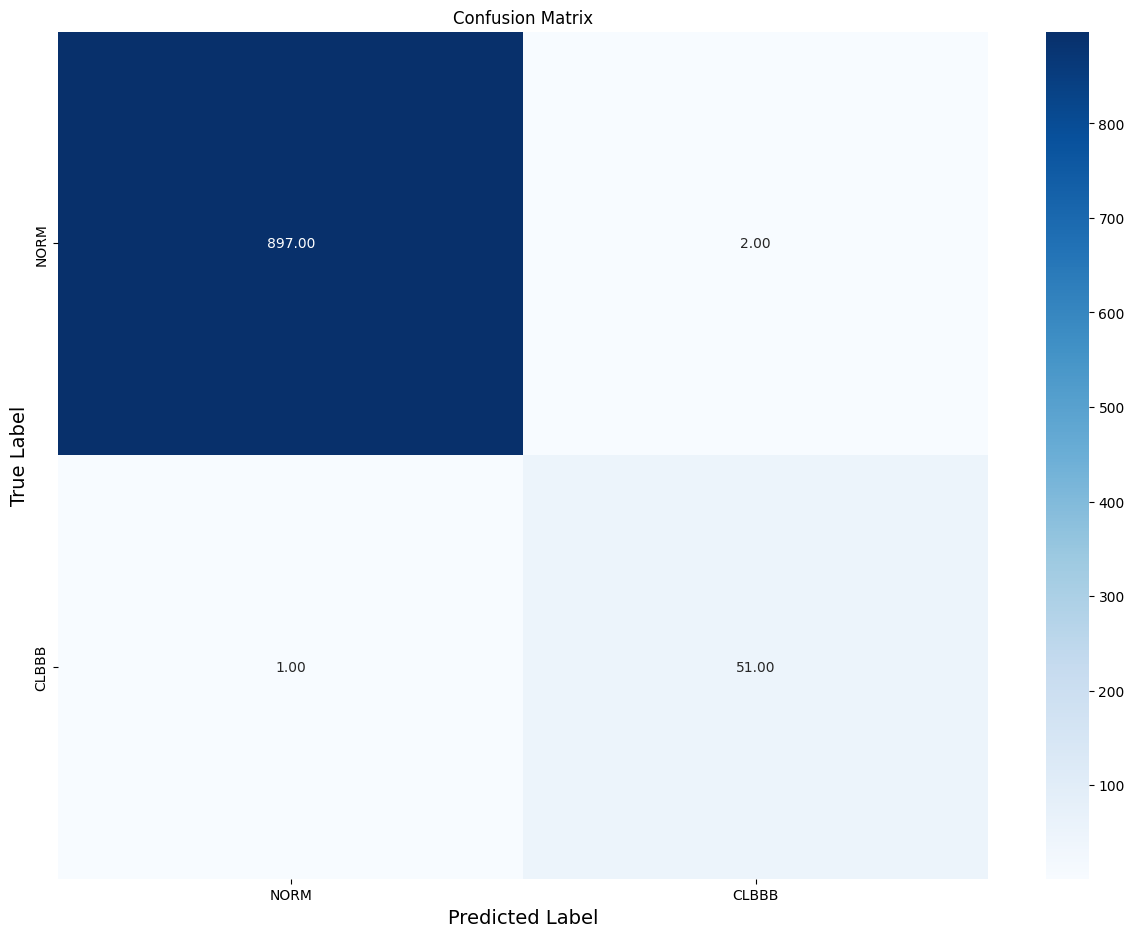

In [130]:
best_model = load_model('best_model.keras')
model1 = best_model
#model1 = model

model1.evaluate([X1_test_0, X1_test_1,X1_test_2,X1_test_3,X1_test_4,X1_test_5,X1_test_6,X1_test_7,X1_test_8,X1_test_9,X1_test_10,X1_test_11,X2_test_0,X2_test_1], Y_test, verbose=1) #,X2_test_0,X2_test_1

# Save the final model and training history
# model1.save('final_model.h5')  # Save the final model
print('Training time (Sec): ',training_duration)
# Confusion Matrix
# Predict on the test set
Y_pred = model1.predict([X1_test_0, X1_test_1,X1_test_2,X1_test_3,X1_test_4,X1_test_5,X1_test_6,X1_test_7,X1_test_8,X1_test_9,X1_test_10,X1_test_11,X2_test_0,X2_test_1]) #,X2_test_0,X2_test_1

# Convert probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

baseline_score = accuracy_score(Y_true_classes, Y_pred_classes)

# Create the confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)
cm_normalized = cm.astype('float') #/ cm.sum(axis=1)[:, np.newaxis]
cm_array_df = pd.DataFrame(cm_normalized, index=classes, columns=classes) # classes  ['NORM', tar_col]

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15,11))#figsize=(9,7) figsize=(15,11)
sns.heatmap(cm_array_df, annot=True, ax=ax ,cbar = True, fmt='0.2f', cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label',fontsize=14)
ax.set_xlabel('Predicted Label',fontsize=14)

# # Save confusion matrix as PNG
plt.savefig('confusion_matrix.png')

plt.show()

# Permutation Feature Importance

In [ ]:
reset_random_seeds() 

input_data=[X1_test_0, X1_test_1,X1_test_2,X1_test_3,X1_test_4,X1_test_5,X1_test_6,X1_test_7,X1_test_8,X1_test_9,X1_test_10,X1_test_11,X2_test_0,X2_test_1]#,X2_test_0,X2_test_1
# Feature permutation
for feature_idx in range(len(input_data)):  # Loop over features
    perturbed_input = input_data.copy()
    # print(permuted_input.shape)
    # Permute the selected feature
    permuted_input = np.random.permutation(perturbed_input[feature_idx])
    # # Replace the input with the permuted version
    
    perturbed_input[feature_idx] = permuted_input
    # print(perturbed_input[0].shape)

    # Perturbed performance
    perturbed_preds = model.predict(perturbed_input)  # Shape: (1903, 1000)
    perturbed_classes = np.argmax(perturbed_preds, axis=1)  # Shape: (1903,)
    perturbed_score = accuracy_score(Y_true_classes, perturbed_classes)
    
    # Feature importance
    importance = baseline_score - perturbed_score
    print(f"Feature {feature_idx}: Importance = {round(importance,3)}")